In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Tampilkan semua kolom (agar tidak di-truncate)
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('Training Data.csv', sep=',')
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


# Data Cleansing

## Handle Missing Value

In [ ]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 252000 non-null  int64 
 1   income             252000 non-null  int64 
 2   age                252000 non-null  int64 
 3   experience         252000 non-null  int64 
 4   married/single     252000 non-null  object
 5   house_ownership    252000 non-null  object
 6   car_ownership      252000 non-null  object
 7   profession         252000 non-null  object
 8   city               252000 non-null  object
 9   state              252000 non-null  object
 10  current_job_yrs    252000 non-null  int64 
 11  current_house_yrs  252000 non-null  int64 
 12  risk_flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [ ]:
df.isnull().sum()\
    .to_frame('missing value')\
    .style.map(lambda val : 'background-color: red' if val > 0 else '' )

,missing value
id,0
income,0
age,0
experience,0
married/single,0
house_ownership,0
car_ownership,0
profession,0
city,0
state,0


Dari data diatas tidak ada missing values

## Handle Duplicated Data

In [ ]:
df.duplicated().sum()

0

Dari data diatas tidak ada Duplicated Data

## Handle Outliers

In [ ]:
df.describe()

,id,income,age,experience,current_job_yrs,current_house_yrs,risk_flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


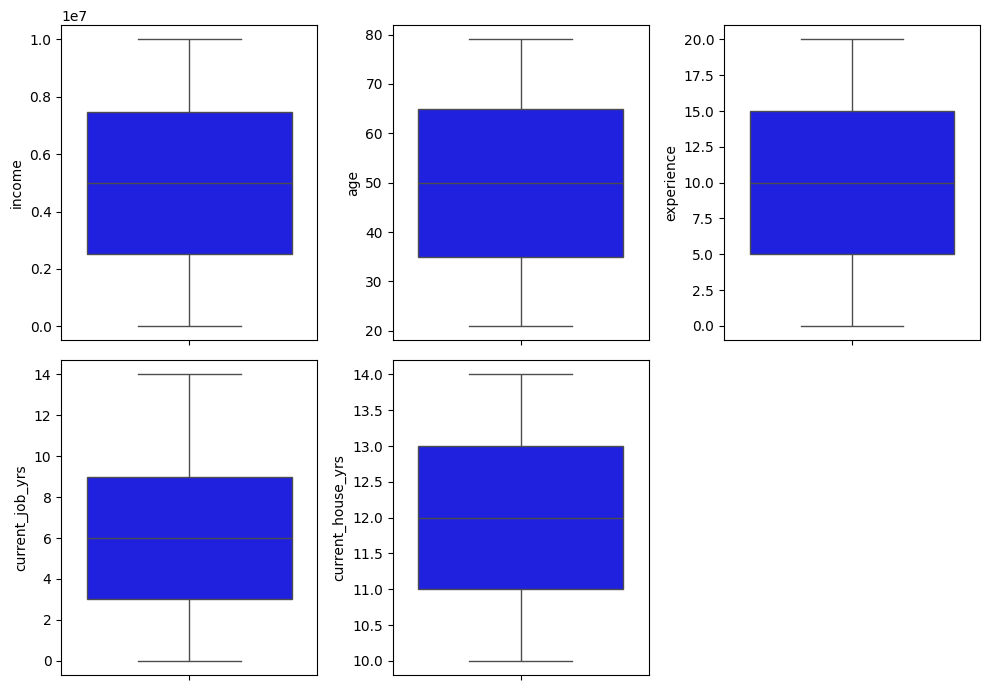

In [ ]:
# Analis Boxplot
nums = ['income', 'age', 'experience', 'current_job_yrs','current_house_yrs']

plt.figure(figsize=(10,7))

for i in range(0, len(nums)):
  plt.subplot(2,3, i+1)
  sns.boxplot(df[nums[i]], orient='v', color='blue')
  plt.tight_layout()

plt.show()

Berdasarkan tabel `desribe`, kolom income menunjukkan adanya outlier akan tetapi jika divisualisasi kan tidak adanya indikasi yang menunjukkan outlier. Kolom lain memiliki kemungkinan adanya outlier lebih kecil.

## **Feature Extraction**


### Membuat fitur baru berupa kategori risk_ratio berdasarkan city

In [ ]:
# Agregasi city berdasarkan risk_flag ratio

df_city_agg = df.groupby('city', as_index = False).agg({'id':'count',
                                                        'risk_flag': lambda x: (x==1).sum()})
# Mengganti Nama Kolom
df_city_agg.columns = ['city', 'total_customer', 'risk_flag']

# Menghitung Ratio
df_city_agg['risk_ratio'] = df_city_agg['risk_flag']/df_city_agg['total_customer']

df_city_agg.sort_values(by='risk_ratio', ascending=False)

,city,total_customer,risk_flag,risk_ratio
54,Bhubaneswar,607,198,0.326194
112,Gwalior,616,168,0.272727
41,Bettiah[33],457,122,0.266958
160,Kochi,961,243,0.252862
240,Raiganj,718,172,0.239554
...,...,...,...,...
30,Bangalore,727,27,0.037139
59,Bijapur,572,20,0.034965
282,Sultan_Pur_Majra,528,18,0.034091
78,Dehradun,873,23,0.026346


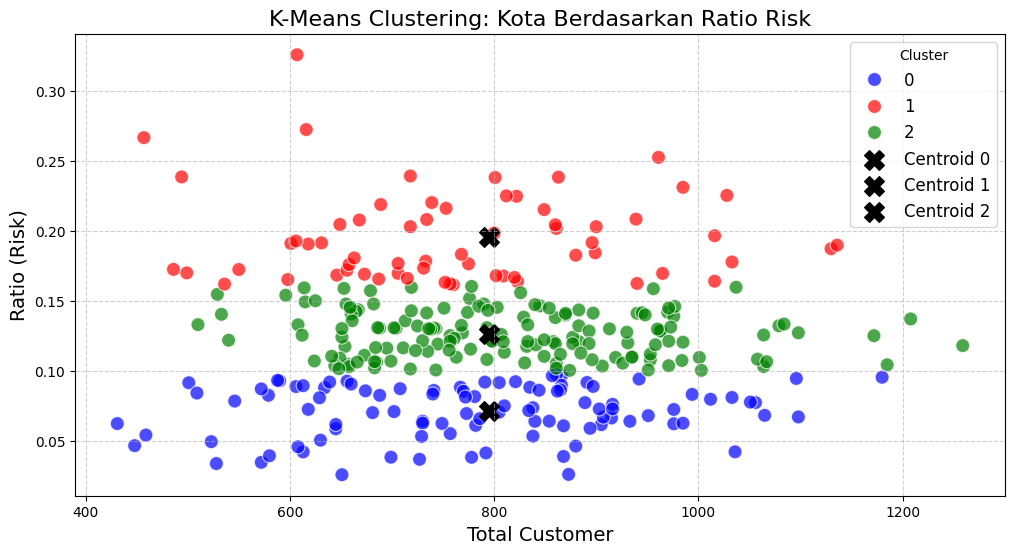

In [ ]:
# Mengkategorikan risk_ratio menggunakan K-Means clusterring

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat model KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Tambahkan n_init=10 untuk menghilangkan warning
df_city_agg['cluster'] = kmeans.fit_predict(df_city_agg[['risk_ratio']])


# Menyiapkan warna untuk setiap cluster
cluster_colors = {0: 'blue', 1: 'red', 2: 'green'}
df_city_agg['color'] = df_city_agg['cluster'].map(cluster_colors)

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='total_customer',
    y='risk_ratio',
    hue='cluster',
    palette=cluster_colors,
    data=df_city_agg,
    s=100,
    alpha=0.7
)

# Menandai pusat cluster
centroids = kmeans.cluster_centers_
for i, c in enumerate(centroids):
    plt.scatter(
        x=df_city_agg['total_customer'].mean(),
        y=c[0],
        color='black',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

# Labeling dan tata letak
plt.title("K-Means Clustering: Kota Berdasarkan Ratio Risk", fontsize=16)
plt.xlabel("Total Customer", fontsize=14)
plt.ylabel("Ratio (Risk)", fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# Membuat kolom city category berdasarkan hasil dari K-Means clustering

df_city_agg['city_category'] = df_city_agg['cluster'].map({0: 'Low Risk', 1: 'High Risk', 2: 'Medium Risk'})

df_city_agg.sort_values(by='risk_ratio', ascending=False)


,city,total_customer,risk_flag,risk_ratio,cluster,color,city_category
54,Bhubaneswar,607,198,0.326194,1,red,High Risk
112,Gwalior,616,168,0.272727,1,red,High Risk
41,Bettiah[33],457,122,0.266958,1,red,High Risk
160,Kochi,961,243,0.252862,1,red,High Risk
240,Raiganj,718,172,0.239554,1,red,High Risk
...,...,...,...,...,...,...,...
30,Bangalore,727,27,0.037139,0,blue,Low Risk
59,Bijapur,572,20,0.034965,0,blue,Low Risk
282,Sultan_Pur_Majra,528,18,0.034091,0,blue,Low Risk
78,Dehradun,873,23,0.026346,0,blue,Low Risk


In [ ]:
# Gabungkan category df_city_agg dengan df yang kita punya

df = df.merge(df_city_agg[['city','city_category']], on='city', how='left' )

df.head()

,id,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag,city_category
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Medium Risk
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Medium Risk
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Medium Risk
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,High Risk
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Medium Risk


Fitur city_category terdiri dari 3 segment
1. Low Risk
2. Medium Risk
3. High Risk

Ketiga segmentasi diatas didapat dari K-Means clustering

### Risk_ratio Profession

In [ ]:
df_profession_agg = df.groupby('profession', as_index = False).agg({'id':'count',
                                                        'risk_flag': lambda x: (x==1).sum()})
# Mengganti Nama Kolom
df_profession_agg.columns = ['profession', 'total_customer', 'risk_flag']

# Menghitung Ratio
df_profession_agg['risk_ratio'] = df_profession_agg['risk_flag']/df_profession_agg['total_customer']

df_profession_agg.sort_values(by='risk_ratio', ascending=False)

,profession,total_customer,risk_flag,risk_ratio
38,Police_officer,5035,826,0.164052
7,Chartered_Accountant,4493,690,0.153572
3,Army_officer,4661,709,0.152113
46,Surveyor,4714,714,0.151464
43,Software_Developer,5053,750,0.148427
41,Scientist,4781,690,0.144321
26,Geologist,4672,674,0.144264
10,Civil_engineer,4616,627,0.135832
35,Official,4087,555,0.135796
24,Firefighter,4507,612,0.135789


<Axes: xlabel='total_customer', ylabel='risk_ratio'>

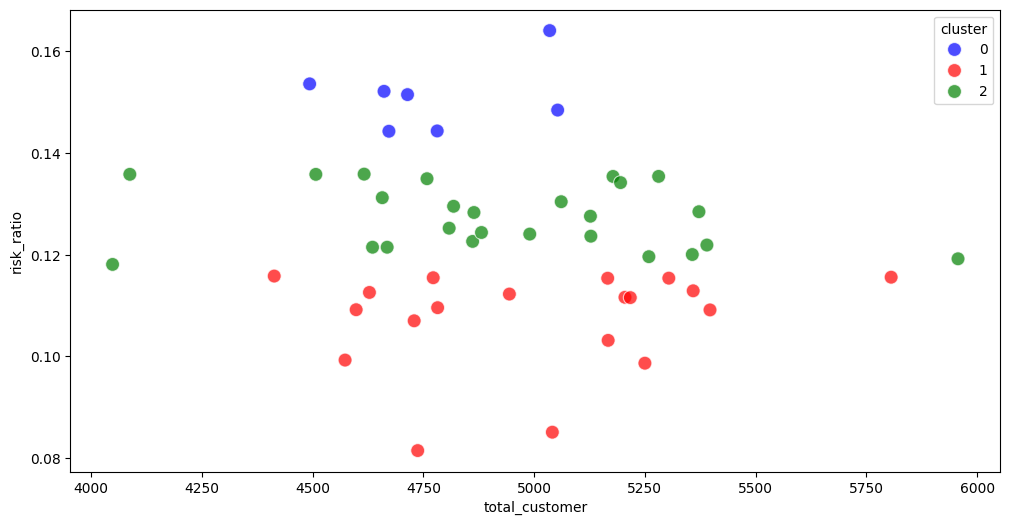

In [ ]:
# Mengkategorikan risk profession dengan menggunakan risk_ratio
df_profession_agg['cluster'] = kmeans.fit_predict(df_profession_agg[['risk_ratio']])
df_profession_agg['color'] = df_profession_agg['cluster'].map(cluster_colors)

# Scatter Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='total_customer',
    y='risk_ratio',
    hue='cluster',
    palette=cluster_colors,
    data=df_profession_agg,
    s=100,
    alpha=0.7
)


In [ ]:
# Membuat kolom city category berdasarkan hasil dari K-Means clustering

df_profession_agg['profession_category'] = df_profession_agg['cluster'].map({0: 'High Risk', 1: 'Low Risk', 2: 'Medium Risk'})

df_profession_agg.sort_values(by='risk_ratio', ascending=False)


,profession,total_customer,risk_flag,risk_ratio,cluster,color,profession_category
38,Police_officer,5035,826,0.164052,0,blue,High Risk
7,Chartered_Accountant,4493,690,0.153572,0,blue,High Risk
3,Army_officer,4661,709,0.152113,0,blue,High Risk
46,Surveyor,4714,714,0.151464,0,blue,High Risk
43,Software_Developer,5053,750,0.148427,0,blue,High Risk
41,Scientist,4781,690,0.144321,0,blue,High Risk
26,Geologist,4672,674,0.144264,0,blue,High Risk
10,Civil_engineer,4616,627,0.135832,2,green,Medium Risk
35,Official,4087,555,0.135796,2,green,Medium Risk
24,Firefighter,4507,612,0.135789,2,green,Medium Risk


In [ ]:
df = df.merge(df_profession_agg[['profession','profession_category']], on='profession', how='left' )

df.head()

,id,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag,city_category,profession_category
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Medium Risk,Low Risk
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Medium Risk,High Risk
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Medium Risk,Medium Risk
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,High Risk,High Risk
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Medium Risk,Low Risk


Fitur profession_category terdiri dari 3 segment
1. Low Risk
2. Medium Risk
3. High Risk

Ketiga segmentasi diatas didapat dari K-Means clustering

## Feature Transformation

### Split data


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['risk_flag','id'])
y = df['risk_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Banyak data latih', X_train.shape[0])
print(f'Banyak data test', X_test.shape[0])

Banyak data latih 201600
Banyak data test 50400


### Encoding Feature Kategorikal


In [ ]:
# Ini hanya opsi jika terjadi error
import sklearn
!pip install scikit-learn --upgrade

In [ ]:
# install library target encoder
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# memilih data yang akan di scale
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Pisahkan kolom berdasarkan kardinalitasnya
fitur_label_encoding = ['married/single', 'house_ownership', 'car_ownership', 'city_category', 'profession_category']
fitur_target_encoding = ['profession','city','state']

# Label encoding
le = LabelEncoder()

for i in fitur_label_encoding:
    le.fit(X_train[i])
    X_train_encoded[i] = le.transform(X_train[i])
    X_test_encoded[i] = le.transform(X_test[i])

#Target Encoding
te = TargetEncoder(cols=fitur_target_encoding, smoothing=3)
te.fit(X_train[fitur_target_encoding], y_train)
X_train_te = te.transform(X_train[fitur_target_encoding])
X_test_te = te.transform(X_test[fitur_target_encoding])


# Drop kolom asli karena datanya sudah diencoding
X_train_encoded[fitur_target_encoding] = X_train_te[fitur_target_encoding]
X_test_encoded[fitur_target_encoding]= X_test_te[fitur_target_encoding]

In [ ]:
X_train_encoded

,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,city_category,profession_category
200471,9121364,70,18,1,2,0,0.120873,0.236842,0.139313,3,11,0,2
92611,2636544,39,0,1,2,0,0.128980,0.078621,0.103837,0,11,1,2
86397,1010539,39,9,1,2,0,0.131487,0.155722,0.128364,4,13,2,2
110500,3897430,21,2,1,2,0,0.129292,0.192362,0.133547,2,12,0,2
185133,9470213,41,5,1,0,1,0.107390,0.114327,0.101142,5,13,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,2357771,59,1,1,2,1,0.151531,0.220877,0.167524,1,12,0,0
103694,9314999,51,20,0,2,0,0.131046,0.124021,0.116077,7,10,2,2
131932,9013930,25,5,1,2,0,0.137370,0.148773,0.139313,5,10,2,2
146867,6660597,40,2,1,2,1,0.111748,0.096322,0.117185,2,14,2,1


### Scaling Data

In [ ]:
#Menscaling dengan RobustScaler
from sklearn.preprocessing import RobustScaler

feature_to_scale = ['income', 'age', 'experience', 'current_job_yrs', 'current_house_yrs']

ss = RobustScaler()

# memilih data yang akan di scale
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# apply robustscaler pada fitur yang dipilih
X_train_scaled[feature_to_scale] = ss.fit_transform(X_train_encoded[feature_to_scale])
X_test_scaled[feature_to_scale] = ss.transform(X_test_encoded[feature_to_scale])

X_train_scaled.head()

,income,age,experience,married/single,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,city_category,profession_category
200471,0.824882,0.666667,0.8,1,2,0,0.120873,0.236842,0.139313,-0.500000,-0.5,0,2
92611,-0.474470,-0.366667,-1.0,1,2,0,0.128980,0.078621,0.103837,-1.000000,-0.5,1,2
86397,-0.800270,-0.366667,-0.1,1,2,0,0.131487,0.155722,0.128364,-0.333333,0.5,2,2
110500,-0.221829,-0.966667,-0.8,1,2,0,0.129292,0.192362,0.133547,-0.666667,0.0,0,2
185133,0.894780,-0.300000,-0.5,1,0,1,0.107390,0.114327,0.101142,-0.166667,0.5,2,1


### Handle Class Imbalance

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Misal X_train dan y_train adalah data yang sudah ada
# y_train adalah target

# Menampilkan distribusi awal
print("Distribusi awal:", Counter(y_train))

# Tentukan jumlah yang diinginkan untuk setiap kelas
target_count_0 = 120960
target_count_1 = 80640

# Menyeimbangkan kelas
# 1. Oversampling kelas minoritas (kelas 1) untuk mencapai 80.640
smote = SMOTE(sampling_strategy={1: target_count_1}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 2. Undersampling kelas mayoritas (kelas 0) untuk mencapai 120.960
undersampler = RandomUnderSampler(sampling_strategy={0: target_count_0}, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# Menampilkan distribusi setelah penyeimbangan
print("Distribusi setelah penyeimbangan:", Counter(y_train_resampled))


Distribusi awal: Counter({0: 176857, 1: 24743})
Distribusi setelah penyeimbangan: Counter({0: 120960, 1: 80640})


### Feature Importance

In [ ]:
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_resampled, y_train_resampled) # fit model decision tree dari data train

DecisionTreeClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_resampled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    y_pred_proba_train = model.predict_proba(X_train_resampled)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train_resampled, y_pred_train))

    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train_resampled, y_pred_train))

    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train_resampled, y_pred_train))

    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train_resampled, y_pred_train))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train_resampled, y_pred_proba_train[:, 1]))


eval_classification(dt)

Accuracy (Test Set): 0.87
Accuracy (Train Set): 0.95
Precision (Test Set): 0.48
Precision (Train Set): 0.89
Recall (Test Set): 0.85
Recall (Train Set): 1.00
F1-Score (Test Set): 0.61
F1-Score (Train Set): 0.94
roc_auc (test-proba): 0.85
roc_auc (train-proba): 0.98


In [ ]:
import plotly.express as px

importance = dt.feature_importances_

# Buat DataFrame untuk visualisasi
fitur_penting = pd.DataFrame({
    'Fitur': X_train_resampled.columns,
    'Koefisien': importance
}).sort_values(by='Koefisien', ascending=True)  # Urutkan ascending untuk horizontal bar

# Plot Feature Importance dengan Plotly Express
fig = px.bar(
    fitur_penting,
    x='Koefisien',
    y='Fitur',
    orientation='h',
    text_auto=True
)

# Tambahkan styling ke layout
fig.update_layout(
    width=1200,
    height=600,
    title='<b>Feature Importance</b>',
    xaxis_title='',
    yaxis_title='',
    showlegend=False,
    paper_bgcolor='rgb(255, 255, 255, 1)',
    plot_bgcolor='rgb(255, 255, 255, 0)',
)

# Tampilkan plot
fig.show()

### Feature Selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Menampilkan variansi untuk setiap fitur
variances = X_train_encoded.var()
print("Variansi untuk setiap fitur:")
print(variances)

# Proses memilih feature
selector = VarianceThreshold(threshold=0.2)
X_train_cek = selector.fit_transform(X_train_encoded)


# Menampilkan nilai variansi setiap kolom dan fitur yang dipilih
print("\nNilai variansi setiap fitur dan status terpilih:")
for feature, variance, is_selected in zip(variances.index, variances.values, selector.get_support()):
    status = "Pilih" if is_selected else "Dibuang"
    print(f"Fitur: {feature}, Variansi: {variance:.4f}, Status: {status}")

Variansi untuk setiap fitur:
income                 8.298498e+12
age                    2.916090e+02
experience             3.600980e+01
married/single         9.192716e-02
house_ownership        1.533933e-01
car_ownership          2.106885e-01
profession             2.825622e-04
city                   2.209429e-03
state                  3.011433e-04
current_job_yrs        1.329554e+01
current_house_yrs      1.956611e+00
city_category          6.005995e-01
profession_category    4.944044e-01
dtype: float64

Nilai variansi setiap fitur dan status terpilih:
Fitur: income, Variansi: 8298498383591.2383, Status: Pilih
Fitur: age, Variansi: 291.6090, Status: Pilih
Fitur: experience, Variansi: 36.0098, Status: Pilih
Fitur: married/single, Variansi: 0.0919, Status: Dibuang
Fitur: house_ownership, Variansi: 0.1534, Status: Dibuang
Fitur: car_ownership, Variansi: 0.2107, Status: Pilih
Fitur: profession, Variansi: 0.0003, Status: Dibuang
Fitur: city, Variansi: 0.0022, Status: Dibuang
Fitur: state

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Membuat dan melatih model Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Menampilkan feature importance
feature_importance = model.feature_importances_

# Menyusun dalam DataFrame agar mudah dibaca
importance_df = pd.DataFrame({
    'Fitur': X_train_resampled.columns,
    'Pentingnya': feature_importance
}).sort_values(by='Pentingnya', ascending=False)

print(importance_df)

                  Fitur  Pentingnya
7                  city    0.156557
0                income    0.149136
1                   age    0.131257
6            profession    0.125716
8                 state    0.103206
2            experience    0.101252
9       current_job_yrs    0.090676
10    current_house_yrs    0.061802
11        city_category    0.020400
5         car_ownership    0.017971
12  profession_category    0.016642
4       house_ownership    0.013374
3        married/single    0.012011


Memilih Fitur-fitur yang akan digunakan dalam modeling

In [ ]:
# Memilih fitur Training
X_train_resampled = X_train_resampled.drop(columns=['city_category', 'profession_category', 'married/single', 'house_ownership', 'car_ownership' ])

# Memilih fitur testing
X_test_scaled = X_test_scaled.drop(columns=['city_category', 'profession_category', 'married/single', 'house_ownership', 'car_ownership' ])

X_train_resampled.head()

,income,age,experience,profession,city,state,current_job_yrs,current_house_yrs
88733,-0.102360,-0.200000,0.0,0.128980,0.169306,0.128089,0.166667,0.5
143236,0.729421,-0.800000,0.1,0.131046,0.057692,0.128089,0.500000,-1.0
5811,-0.722764,0.033333,0.1,0.145655,0.173664,0.128089,0.666667,-1.0
71750,0.078329,0.700000,0.0,0.077830,0.068750,0.128089,-0.166667,-1.0
156313,0.179258,-0.400000,0.5,0.114323,0.078621,0.103837,1.166667,-1.0


# **Modeling**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_resampled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    y_pred_proba_train = model.predict_proba(X_train_resampled)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train_resampled, y_pred_train))

    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train_resampled, y_pred_train))

    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train_resampled, y_pred_train))

    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train_resampled, y_pred_train))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train_resampled, y_pred_proba_train[:, 1]))
    #
    # score = cross_validate(model, X, y, cv=5, scoring='recall', return_train_score=True)
    # print('recall (crossval train): '+ str(score['train_score'].mean()))
    # print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt_model = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt_model.fit(X_train_resampled, y_train_resampled) # fit model decision tree dari data train

eval_classification(dt_model)

Accuracy (Test Set): 0.86
Accuracy (Train Set): 0.95
Precision (Test Set): 0.47
Precision (Train Set): 0.89
Recall (Test Set): 0.84
Recall (Train Set): 1.00
F1-Score (Test Set): 0.61
F1-Score (Train Set): 0.94
roc_auc (test-proba): 0.85
roc_auc (train-proba): 0.98


## Tuning Hyperparameter

### max_depth

param value: 10; train: 0.4226934523809524; test: 0.3946905485367024
param value: 11; train: 0.6169890873015873; test: 0.5696465696465697
param value: 12; train: 0.636297123015873; test: 0.58308012154166
param value: 14; train: 0.7600818452380952; test: 0.6811130657284503
param value: 15; train: 0.8264136904761905; test: 0.7449224372301295
param value: 17; train: 0.8720982142857143; test: 0.7676315368623061
param value: 18; train: 0.9063616071428572; test: 0.7991364145210299
param value: 20; train: 0.9402777777777778; test: 0.8148088917319687
param value: 21; train: 0.956187996031746; test: 0.8237645929953622
param value: 22; train: 0.9713541666666666; test: 0.8327202942587558
param value: 24; train: 0.9814732142857143; test: 0.8349592195746042
param value: 25; train: 0.9868675595238096; test: 0.835918758995682
param value: 27; train: 0.9952380952380953; test: 0.842475611706381
param value: 28; train: 0.9950272817460317; test: 0.8387973772589157
param value: 30; train: 0.99780505952380

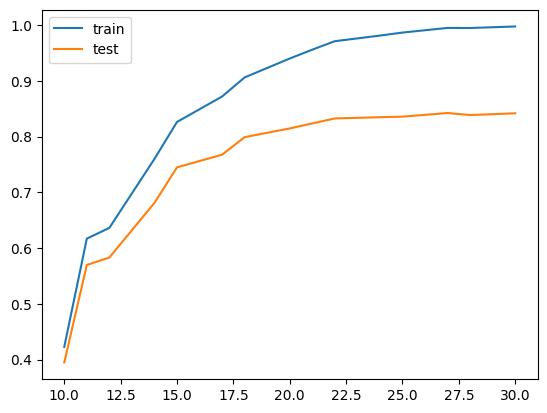

In [ ]:
# RECALL mac_depth LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(10, 30, 15)]

train_scores = []
test_scores = []

for n in param_values:
    model = DecisionTreeClassifier(max_depth=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### min_samples_split

param value: 20; train: 0.9699900793650794; test: 0.8426355349432273
param value: 22; train: 0.9687003968253968; test: 0.842475611706381
param value: 25; train: 0.9664558531746031; test: 0.8410363025747641
param value: 28; train: 0.9631820436507936; test: 0.8405565328642252
param value: 31; train: 0.9607638888888889; test: 0.83991683991684
param value: 34; train: 0.9589285714285715; test: 0.8391172237326083
param value: 37; train: 0.9568576388888889; test: 0.8387973772589157
param value: 40; train: 0.9545386904761904; test: 0.8387973772589157
param value: 43; train: 0.9513020833333333; test: 0.8370382216536063
param value: 46; train: 0.9487103174603174; test: 0.8367183751799137


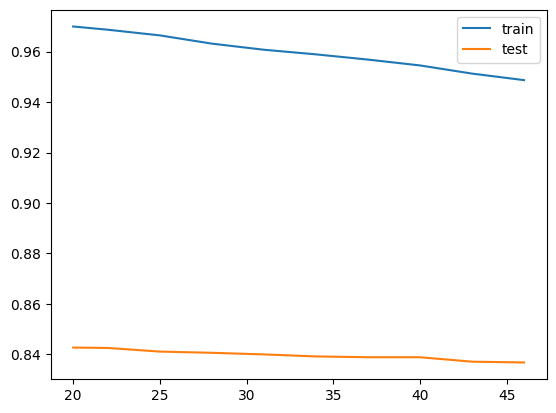

In [ ]:
# RECALL min_samples_split LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(20, 46, 10)]

train_scores = []
test_scores = []

for n in param_values:
    model = DecisionTreeClassifier(min_samples_split=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### min_samples_leaf

param value: 20; train: 0.9073536706349207; test: 0.8407164561010715
param value: 21; train: 0.902703373015873; test: 0.8375179913641452
param value: 23; train: 0.8955605158730159; test: 0.8341596033903727
param value: 24; train: 0.8902405753968254; test: 0.8300015992323685
param value: 26; train: 0.8831225198412699; test: 0.825203902126979
param value: 27; train: 0.8798859126984127; test: 0.8228050535742844
param value: 29; train: 0.8753720238095238; test: 0.8197665120742044
param value: 30; train: 0.8728546626984127; test: 0.8176875099952023
param value: 32; train: 0.8683159722222222; test: 0.8146489684951224
param value: 34; train: 0.8650421626984127; test: 0.8130497361266592


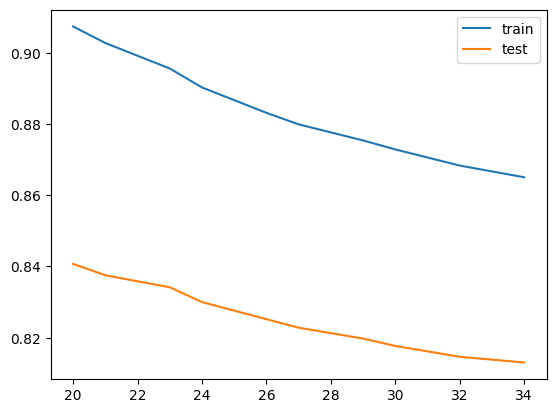

In [ ]:
# RECALL min_samples_leaf LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(20, 34, 10)]

train_scores = []
test_scores = []

for n in param_values:
    model = DecisionTreeClassifier(min_samples_leaf=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### max_features

param value: 75; train: 0.9989459325396826; test: 0.841995841995842
param value: 77; train: 0.9989459325396826; test: 0.8403966096273788
param value: 80; train: 0.9989459325396826; test: 0.8429553814169198
param value: 83; train: 0.9989459325396826; test: 0.8429553814169198
param value: 86; train: 0.9989459325396826; test: 0.8431153046537662
param value: 88; train: 0.9989459325396826; test: 0.8413561490484568
param value: 91; train: 0.9989459325396826; test: 0.8410363025747641
param value: 94; train: 0.9989459325396826; test: 0.8427954581800736
param value: 97; train: 0.9989459325396826; test: 0.8408763793379178
param value: 100; train: 0.9989459325396826; test: 0.8423156884695346


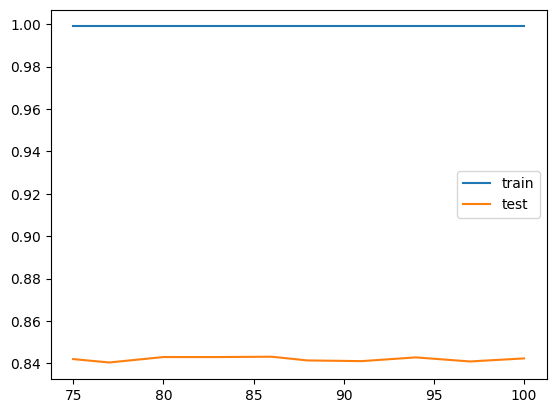

In [ ]:
# RECALL max_features LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(75, 100, 10)]

train_scores = []
test_scores = []

for n in param_values:
    model = DecisionTreeClassifier(max_features=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### max_leaf_nodes

param value: 920; train: 0.8538194444444445; test: 0.8023348792579562
param value: 921; train: 0.8539930555555556; test: 0.8023348792579562
param value: 922; train: 0.854389880952381; test: 0.8026547257316488
param value: 923; train: 0.854389880952381; test: 0.8026547257316488
param value: 924; train: 0.8541170634920635; test: 0.8026547257316488
param value: 925; train: 0.8541046626984127; test: 0.8024948024948025
param value: 926; train: 0.8540674603174603; test: 0.8026547257316488
param value: 927; train: 0.8544394841269841; test: 0.8032944186790341
param value: 928; train: 0.8544394841269841; test: 0.8032944186790341
param value: 929; train: 0.855171130952381; test: 0.8040940348632656
param value: 930; train: 0.8553571428571428; test: 0.8040940348632656
param value: 931; train: 0.8553571428571428; test: 0.8040940348632656
param value: 932; train: 0.8566344246031746; test: 0.8053734207580362
param value: 933; train: 0.8565228174603174; test: 0.8053734207580362
param value: 934; train

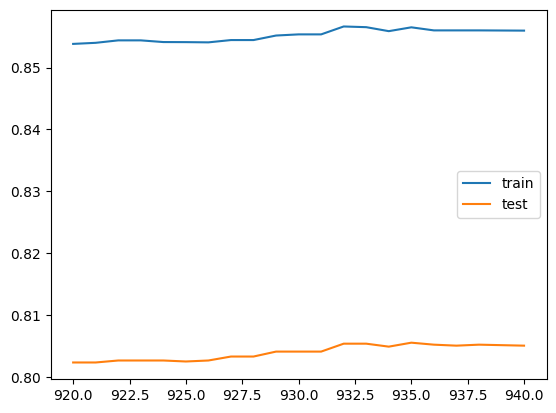

In [ ]:
# RECALL max_leaf_nodes LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(920, 940, 20)]

train_scores = []
test_scores = []

for n in param_values:
    model = DecisionTreeClassifier(max_leaf_nodes=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### Random Search

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, make_scorer

dt = DecisionTreeClassifier(random_state=42)

# Mendefinisikan parameter grid yang akan dicoba
param_dist = {
    'max_depth': [20, 21, 22, 24, 25, 26, 27],
    'min_samples_split': [20, 22, 25, 28, 31, 46],
    'min_samples_leaf': [20, 21, 22, 23, 24, 25, 26, 27],
    'max_features': [1, 80, 83, 86, 100],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [930, 931, 932, 934, 935]
}

# Mendefinisikan scoring yang ingin digunakan
scoring = {
    'recall': make_scorer(recall_score, average='macro', zero_division=1),
    'precision': 'precision_macro'
}

# RandomizedSearchCV untuk tuning hyperparameter
random_search_dt = RandomizedSearchCV(estimator=dt,
                                   param_distributions=param_dist,
                                   n_iter=100,  # Jumlah kombinasi yang diuji
                                   scoring=scoring,
                                   cv=5,  # Validasi silang dengan 5 fold
                                   refit='recall',  # Gunakan recall untuk memilih model terbaik
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)


random_search_dt.fit(X_train_resampled, y_train_resampled)
eval_classification(random_search_dt)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy (Test Set): 0.85
Accuracy (Train Set): 0.86
Precision (Test Set): 0.44
Precision (Train Set): 0.80
Recall (Test Set): 0.80
Recall (Train Set): 0.85
F1-Score (Test Set): 0.57
F1-Score (Train Set): 0.83
roc_auc (test-proba): 0.85
roc_auc (train-proba): 0.89


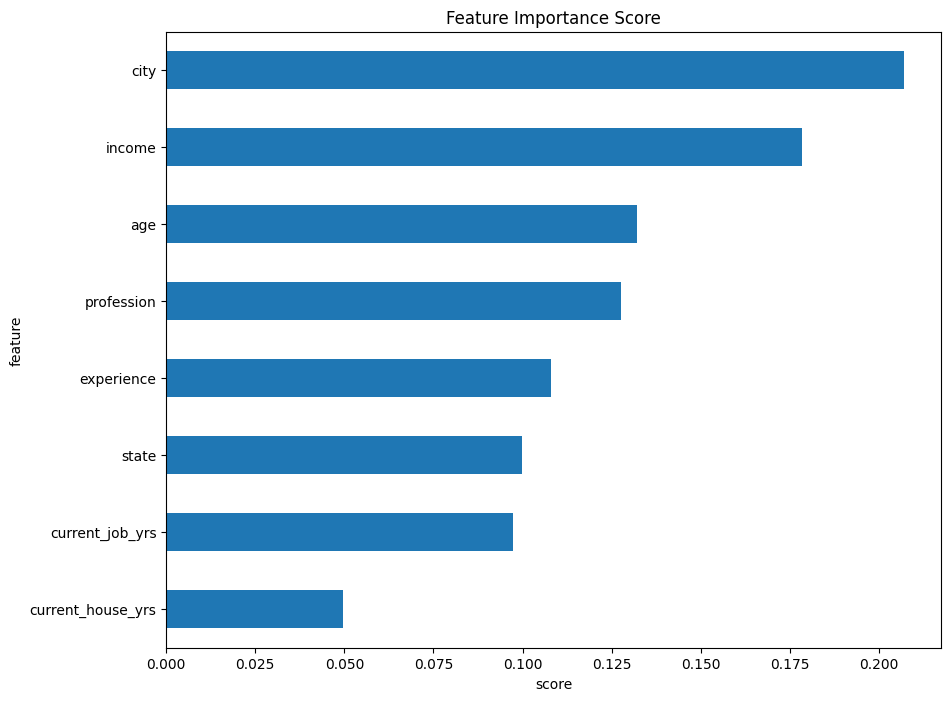

In [ ]:
def show_feature_importance(random_search_model):
    # Ambil model terbaik yang ditemukan oleh RandomizedSearchCV
    best_model = random_search_model.best_estimator_

    # Ambil feature importances dari model terbaik
    feat_importances = pd.Series(best_model.feature_importances_, index=X_train_resampled.columns)

    # Plot feature importances
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('Feature Importance Score')

# Panggil fungsi dengan objek RandomizedSearchCV
show_feature_importance(random_search_dt)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [ ]:
# Evaluasi Model Logistic Regression
eval_classification(lr)

Accuracy (Test Set): 0.80
Accuracy (Train Set): 0.62
Precision (Test Set): 0.22
Precision (Train Set): 0.57
Recall (Test Set): 0.24
Recall (Train Set): 0.25
F1-Score (Test Set): 0.23
F1-Score (Train Set): 0.34
roc_auc (test-proba): 0.62
roc_auc (train-proba): 0.63


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
eval_classification(rf_model)

Accuracy (Test Set): 0.89
Accuracy (Train Set): 0.95
Precision (Test Set): 0.54
Precision (Train Set): 0.89
Recall (Test Set): 0.77
Recall (Train Set): 1.00
F1-Score (Test Set): 0.64
F1-Score (Train Set): 0.94
roc_auc (test-proba): 0.94
roc_auc (train-proba): 0.97


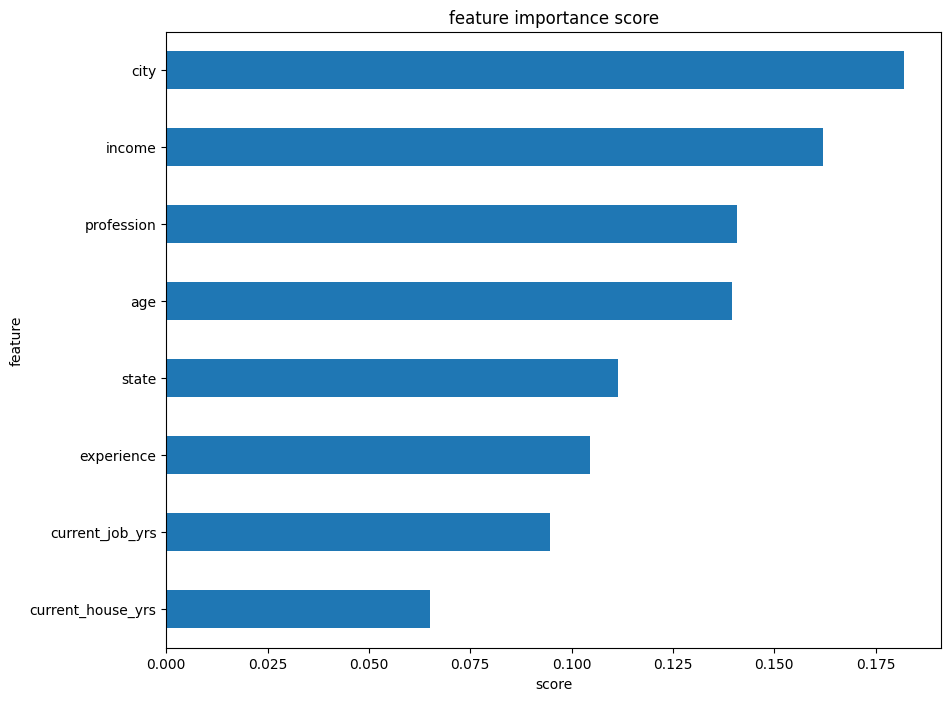

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train_resampled.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

show_feature_importance(rf_model)

## **Tuning Hyperparameter**

### Logistic regression

In [ ]:
# Tuning dengan RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
hyperparameters = dict(penalty=penalty, C=C)

lr = LogisticRegression(solver='saga' )
rs = RandomizedSearchCV(lr, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=50)
rs.fit(X_train_resampled, y_train_resampled)
eval_classification(rs)

Accuracy (Test Set): 0.80
Accuracy (Train Set): 0.63
Precision (Test Set): 0.23
Precision (Train Set): 0.12
Recall (Test Set): 0.25
Recall (Train Set): 0.18
F1-Score (Test Set): 0.24
F1-Score (Train Set): 0.15
roc_auc (test-proba): 0.63
roc_auc (train-proba): 0.64


In [ ]:
# Tuning dengan GridSearch
# Mendefinisikan parameter yang akan diuji
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 500],
    'class_weight': ['balanced', None]
}

gs = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train_resampled, y_train_resampled)
eval_classification(gs)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


360 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_s

Accuracy (Test Set): 0.59
Accuracy (Train Set): 0.59
Precision (Test Set): 0.17
Precision (Train Set): 0.12
Recall (Test Set): 0.59
Recall (Train Set): 0.48
F1-Score (Test Set): 0.26
F1-Score (Train Set): 0.19
roc_auc (test-proba): 0.63
roc_auc (train-proba): 0.64


In [ ]:
# menampilkan parameter terbaik
show_best_hyperparameter(rs)

{'C': 0.05, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
show_best_hyperparameter(gs)

{'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Random Forest Classifier

### Learning Curve

#### n_estimator

param value: 1; train: 0.9488413277546985; test: 0.8503459055896628
param value: 5; train: 0.9712468996990675; test: 0.9253939172463126
param value: 9; train: 0.9719146628046231; test: 0.933805181445495
param value: 13; train: 0.9720159586096446; test: 0.9363217780864419
param value: 17; train: 0.9721689275150646; test: 0.9372127631936208
param value: 21; train: 0.9722146970646862; test: 0.9376362697888162
param value: 25; train: 0.9722273089978418; test: 0.9379304724680575
param value: 29; train: 0.9722860529905925; test: 0.9379105413821598
param value: 33; train: 0.9721796962961978; test: 0.9377344671554052
param value: 37; train: 0.972269633267442; test: 0.9384650707773979
param value: 41; train: 0.9723034235335241; test: 0.937973623884854
param value: 45; train: 0.9723143982769128; test: 0.93805968400984
param value: 49; train: 0.9722686485136107; test: 0.9382549720642211
param value: 53; train: 0.9724026933424796; test: 0.9378779822036704
param value: 57; train: 0.9724308707013862

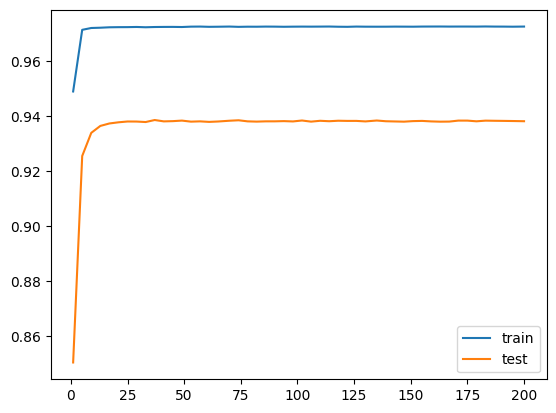

In [ ]:
import matplotlib.pyplot as plt

param_values = [int(x) for x in np.linspace(1, 200, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train_proba = model.predict_proba(X_train_resampled)
    train_auc = roc_auc_score(y_train_resampled, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # evaluasi on test
    y_pred_proba = model.predict_proba(X_test_scaled)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()

Interpretasi : n_estimastors dari nilai ROC_AUC nya hampir sama disetiap iterasi kita bisa pakai 25-60

n_estimators menentukan berapa jumlah pohon yang membentuk random forest, semakin tinggi nilainya akan cenderung akurasi tetapi juga lambat karena membutuhkan banyak sumber daya komputasi

param value: 1; train: 0.9699280753968254; test: 0.845034383495922
param value: 5; train: 0.9928571428571429; test: 0.820086358547897
param value: 9; train: 0.9965029761904762; test: 0.8090516552055014
param value: 13; train: 0.9982514880952381; test: 0.7991364145210299
param value: 17; train: 0.9987227182539683; test: 0.7919398688629458
param value: 21; train: 0.9989707341269841; test: 0.7895410203102511
param value: 25; train: 0.999280753968254; test: 0.7861826323364784
param value: 29; train: 0.9992435515873016; test: 0.7898608667839437
param value: 33; train: 0.9993675595238095; test: 0.7847433232048616
param value: 37; train: 0.9989087301587302; test: 0.7853830161522469
param value: 41; train: 0.9989459325396826; test: 0.7844234767311691
param value: 45; train: 0.9992931547619047; test: 0.7817047817047817
param value: 49; train: 0.9991443452380953; test: 0.7813849352310891
param value: 53; train: 0.9989335317460317; test: 0.7788261634415481
param value: 57; train: 0.99909474206349

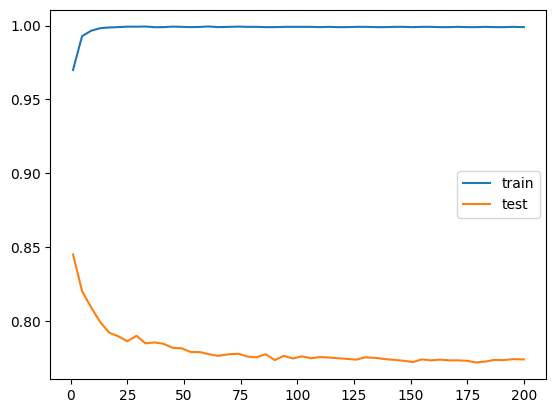

In [ ]:
# RECALL n_estimator LEARNING CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(1, 200, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


#### max_depth

param value: 2; train: 0.6325885848890096; test: 0.6136758181927207
param value: 4; train: 0.6640841108639153; test: 0.637473741238088
param value: 6; train: 0.7128234599805393; test: 0.6738728234648335
param value: 8; train: 0.7919287262642085; test: 0.7417794205423298
param value: 10; train: 0.8757091869951106; test: 0.8164409640239516
param value: 12; train: 0.9335948026219312; test: 0.8735906866636196
param value: 14; train: 0.9555559687103042; test: 0.9042636534033284
param value: 16; train: 0.9619390584648211; test: 0.9229957877631472
param value: 18; train: 0.964467684142764; test: 0.9335243168720834
param value: 20; train: 0.9663526328681067; test: 0.936965377917895
param value: 22; train: 0.9683605603337978; test: 0.9381351681978435
param value: 24; train: 0.9698611918967047; test: 0.9380922033406478
param value: 26; train: 0.9711384125409424; test: 0.9382579063026031
param value: 28; train: 0.9717395412182042; test: 0.9379517384512932
param value: 30; train: 0.972122199815497

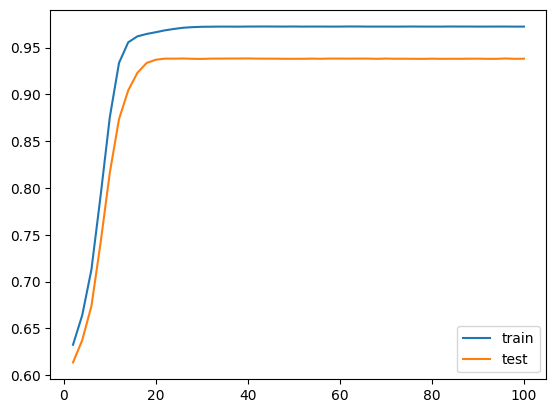

In [ ]:
param_values = [int(x) for x in np.linspace(2, 100, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=60, max_depth=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train_proba = model.predict_proba(X_train_resampled)
    train_auc = roc_auc_score(y_train_resampled, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # evaluasi on test
    y_pred_proba = model.predict_proba(X_test_scaled)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()

Interpretasi : max_depth dari nilai ROC_AUC berdasarkan hasil diatas kita bisa pakai dari 2-20 dari segi perbedaan nilai yang lebih kecil

max_depth adalah hyperparameter penting yang mengontrol kompleksitas kedalaman pohon keputusan. Nilai yang terlalu kecil menyebabkan underfitting, sedangkan nilai yang terlalu besar menyebabkan overfitting.

param value: 2; train: 0.0; test: 0.0
param value: 2; train: 0.011297123015873016; test: 0.0
param value: 2; train: 0.01899801587301587; test: 0.017271709579401887
param value: 3; train: 0.1996155753968254; test: 0.17671517671517672
param value: 3; train: 0.060714285714285714; test: 0.03822165360626899
param value: 4; train: 0.14990079365079365; test: 0.13865344634575405
param value: 4; train: 0.21805555555555556; test: 0.20022389253158485
param value: 5; train: 0.20100446428571428; test: 0.18519110826803134
param value: 5; train: 0.18937251984126985; test: 0.18391172237326084
param value: 6; train: 0.2916046626984127; test: 0.2517191747960979
param value: 6; train: 0.2532862103174603; test: 0.23172877019030866
param value: 7; train: 0.26788194444444446; test: 0.23172877019030866
param value: 7; train: 0.29136904761904764; test: 0.26083479929633774
param value: 8; train: 0.3174231150793651; test: 0.25491763953302415
param value: 8; train: 0.37336309523809524; test: 0.3204861666400128
p

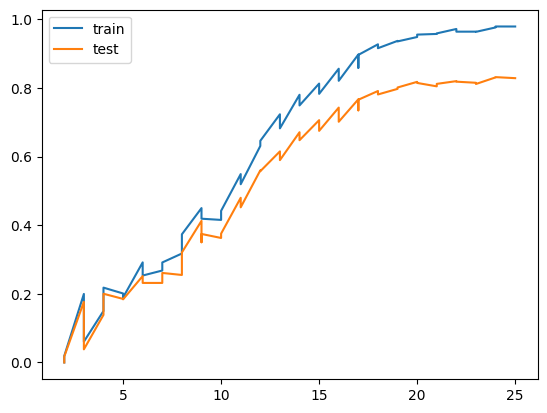

In [ ]:
# RECALL LEARNING CURVE MAX DEPTH

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(2, 25, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=3, max_depth=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


#### min_samples_split

param value: 2; train: 0.9723017919310857; test: 0.9379001701173606
param value: 7; train: 0.9680663915896701; test: 0.9381282691151295
param value: 12; train: 0.9667896685764874; test: 0.9380917849399897
param value: 17; train: 0.9652490002680277; test: 0.9377898626780422
param value: 22; train: 0.9638892962000096; test: 0.9380399539736093
param value: 27; train: 0.9631618185468631; test: 0.9380949292843297
param value: 32; train: 0.9627210588071553; test: 0.9380464092980494
param value: 37; train: 0.9621650080810199; test: 0.9379352089084085
param value: 42; train: 0.9618590189077656; test: 0.9381616560386439
param value: 47; train: 0.9616304862029688; test: 0.9381371171117316
param value: 52; train: 0.9612137129157218; test: 0.9382427134683147
param value: 57; train: 0.9610713947398982; test: 0.9377965462210232
param value: 62; train: 0.9607871363787124; test: 0.9375229339256863
param value: 68; train: 0.9605068400998035; test: 0.9374593515157121
param value: 73; train: 0.9602817356

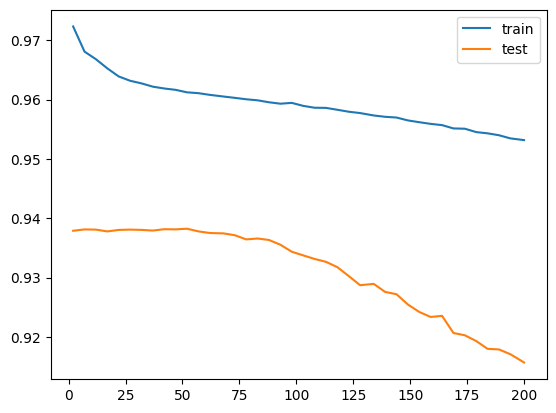

In [ ]:
param_values = [int(x) for x in np.linspace(2, 200, 40)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=60, min_samples_split=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train_proba = model.predict_proba(X_train_resampled)
    train_auc = roc_auc_score(y_train_resampled, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # evaluasi on test
    y_pred_proba = model.predict_proba(X_test_scaled)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()

Interpretasi : min_samples_split dari nilai ROC_AUC diatas yang dapat kita gunakan sekitar rentang 50-100

min_samples_split mengontrol kompleksitas pohon keputusan dengan membatasi jumlah minimum sampel untuk pemisahan node.

param value: 2; train: 0.9867683531746032; test: 0.825683671837518
param value: 2; train: 0.9861855158730158; test: 0.83383975691668
param value: 2; train: 0.9872891865079365; test: 0.8284023668639053
param value: 3; train: 0.9798983134920635; test: 0.8210458979689749
param value: 3; train: 0.9796502976190476; test: 0.825683671837518
param value: 4; train: 0.9767857142857143; test: 0.8220054373900528
param value: 4; train: 0.9774553571428571; test: 0.819606588837358
param value: 5; train: 0.9756696428571429; test: 0.8260035183112107
param value: 5; train: 0.9763392857142857; test: 0.8248840556532864
param value: 6; train: 0.974578373015873; test: 0.8274428274428275
param value: 6; train: 0.9730530753968254; test: 0.8258435950743643
param value: 7; train: 0.9741319444444444; test: 0.8236046697585159
param value: 7; train: 0.9733878968253968; test: 0.8237645929953622
param value: 8; train: 0.9736855158730159; test: 0.8269630577322885
param value: 8; train: 0.9737847222222222; test: 0.823

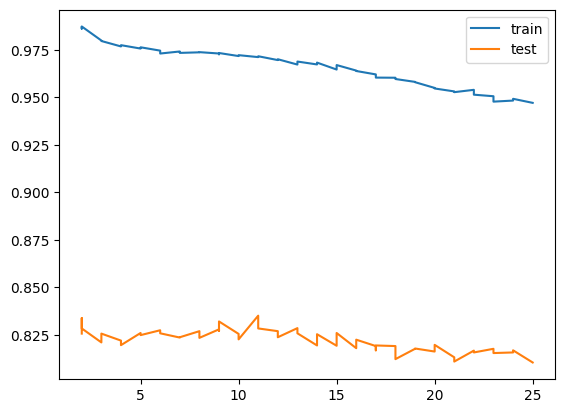

In [ ]:
 # RECALL LEARNING CURVE MIN SAMPLE SPLIT

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(2, 25, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=3, min_samples_split=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


#### min_samples_leaf

param value: 1; train: 0.9723293465847953; test: 0.9380092495235783
param value: 1; train: 0.9724137323657761; test: 0.9380690844402116
param value: 2; train: 0.966946704083109; test: 0.9379299779945525
param value: 3; train: 0.9644195628917076; test: 0.9380328647087779
param value: 4; train: 0.9628483822336322; test: 0.9378989583855843
param value: 5; train: 0.9618223689034352; test: 0.9379642216432242
param value: 6; train: 0.9611161575451941; test: 0.9381013846087699
param value: 7; train: 0.9605110732444019; test: 0.9378072797374746
param value: 8; train: 0.9598165639049312; test: 0.9379286485309893
param value: 9; train: 0.9596335086708777; test: 0.9379322094647292
param value: 9; train: 0.9594629072332057; test: 0.9379784146629528
param value: 10; train: 0.9592655858579446; test: 0.937715840175455
param value: 11; train: 0.9591242095314206; test: 0.9375167539125016
param value: 12; train: 0.9586838128142846; test: 0.9373740919668773
param value: 13; train: 0.958500509174783; test

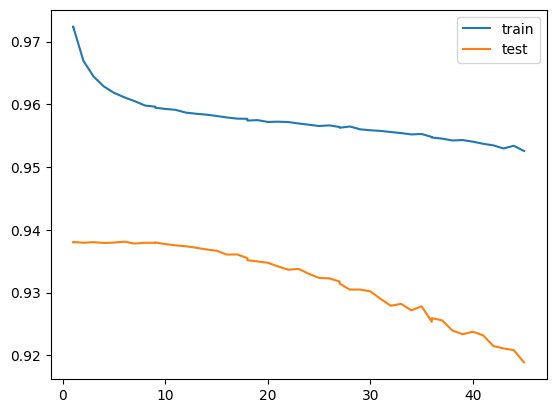

In [ ]:
param_values = [int(x) for x in np.linspace(1, 45, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=60, min_samples_leaf=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train_proba = model.predict_proba(X_train_resampled)
    train_auc = roc_auc_score(y_train_resampled, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # evaluasi on test
    y_pred_proba = model.predict_proba(X_test_scaled)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()

Interpretasi : min_samples_leaf dari nilai ROC_AUC diatas yang dapat digunakan sekitar 2-30

min_samples_leaf: Mengatur jumlah sampel minimum agar sebuah node bisa menjadi daun setelah pembagian.

param value: 1; train: 0.9859250992063492; test: 0.8330401407324485
param value: 1; train: 0.9864583333333333; test: 0.8280825203902127
param value: 2; train: 0.9665922619047619; test: 0.8255237486006717
param value: 3; train: 0.9543774801587301; test: 0.8218455141532065
param value: 4; train: 0.943328373015873; test: 0.8173676635215097
param value: 5; train: 0.934796626984127; test: 0.8168878938109707
param value: 6; train: 0.9273685515873016; test: 0.8100111946265792
param value: 7; train: 0.9218377976190476; test: 0.8122501199424277
param value: 8; train: 0.9161706349206349; test: 0.8111306572845034
param value: 9; train: 0.9097594246031746; test: 0.8044138813369582
param value: 9; train: 0.9080729166666667; test: 0.8020150327842636
param value: 10; train: 0.9036706349206349; test: 0.8056932672317287
param value: 11; train: 0.901438492063492; test: 0.7994562609947226
param value: 12; train: 0.9008804563492063; test: 0.8024948024948025
param value: 13; train: 0.89609375; test: 0.7991

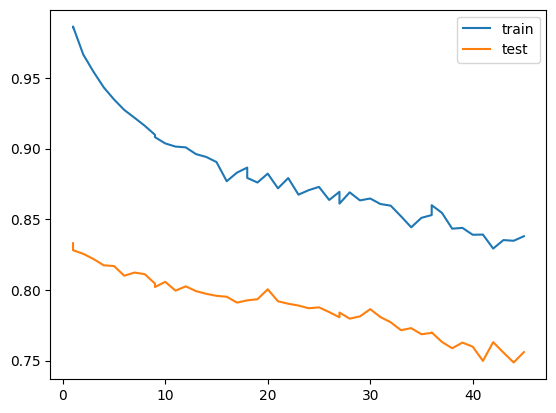

In [ ]:
 # RECALL LEARNING CURVE MIN SAMPLE SPLIT

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

param_values = [int(x) for x in np.linspace(1, 45, 50)]

train_scores = []
test_scores = []

for n in param_values:
    model = RandomForestClassifier(n_estimators=3, min_samples_leaf=n)
    model.fit(X_train_resampled, y_train_resampled)

    # evaluasi on train
    y_pred_train = model.predict(X_train_resampled)
    train_recall = recall_score(y_train_resampled, y_pred_train)
    train_scores.append(train_recall)

    # evaluasi on test
    y_pred = model.predict(X_test_scaled)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(n) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend()
plt.show()


### Tuning RandomizedSearch & GridSearch

### Percobaan 1

In [ ]:
# Tuning dengan RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import randint

scoring = {
    'roc_auc': 'roc_auc',
    'recall': make_scorer(recall_score)
}

rfs = RandomForestClassifier(random_state=42)

# mendifinisikan parameter distribusi
param_dist = {
    'n_estimators' : [25, 33, 49, 57, 60],
    'max_depth' : [2, 8, 12, 18, 20],
    'min_samples_split' : [52, 62, 73, 83, 93, 100],
    'min_samples_leaf' : [3, 8, 10, 15, 20, 25, 30],
    'max_features' : ['auto', 'sqrt', 'log2', None],
}

random_search = RandomizedSearchCV(estimator=rfs, param_distributions=param_dist, n_iter=100, scoring=scoring, refit='recall', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_resampled, y_train_resampled)
eval_classification(random_search)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Accuracy (Test Set): 0.89
Accuracy (Train Set): 0.91
Precision (Test Set): 0.55
Precision (Train Set): 0.88
Recall (Test Set): 0.76
Recall (Train Set): 0.90
F1-Score (Test Set): 0.64
F1-Score (Train Set): 0.89
roc_auc (test-proba): 0.93
roc_auc (train-proba): 0.96


### Percobaan 2

In [ ]:
# Tuning dengan RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import randint

scoring = {
    'roc_auc': 'roc_auc',
    'recall': make_scorer(recall_score)
}

rfs = RandomForestClassifier(random_state=42)

# mendifinisikan parameter distribusi
param_dist = {
    'n_estimators' : [1,2,3,4,5],
    'max_depth' : [13,14,15,16,17,18,19,20,21,22,23],
    'min_samples_split' : [2,6,9,25],
    'min_samples_leaf' : [5,6,7,8,9,10],
    'max_features' : ['auto', 'sqrt', 'log2', None],
}

scoring = {
    'recall': make_scorer(recall_score),
    'precision' : 'precision'

}

random_search_percobaan1 = RandomizedSearchCV(
    estimator=rfs,
    param_distributions=param_dist,
    n_iter=25,
    scoring=scoring,
    refit='recall',  # Pilih model terbaik berdasarkan recall
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_percobaan1.fit(X_train_resampled, y_train_resampled)
eval_classification(random_search_percobaan1)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


35 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils

Accuracy (Test Set): 0.88
Accuracy (Train Set): 0.91
Precision (Test Set): 0.50
Precision (Train Set): 0.86
Recall (Test Set): 0.80
Recall (Train Set): 0.92
F1-Score (Test Set): 0.62
F1-Score (Train Set): 0.89
roc_auc (test-proba): 0.90
roc_auc (train-proba): 0.95


### Percobaan 3

In [ ]:

# Tuning dengan RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import randint

rfs = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators' : [1,2,3,4,5,9,25,30],
    'max_depth' : [8,10,12,14,20,30],
    'min_samples_split' : [2,7,12,27,47,57,62],
    'min_samples_leaf' : [1,5,8,9,15,20],
    'max_features' : ['auto', 'sqrt', 'log2', None],
}

scoring = {
    'recall': make_scorer(recall_score),
    'precision' : 'precision'

}

random_search_percobaan = RandomizedSearchCV(
    estimator=rfs,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scoring,
    refit='recall',  # Pilih model terbaik berdasarkan recall
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_percobaan.fit(X_train_resampled, y_train_resampled)
eval_classification(random_search_percobaan)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_p

Accuracy (Test Set): 0.89
Accuracy (Train Set): 0.94
Precision (Test Set): 0.54
Precision (Train Set): 0.88
Recall (Test Set): 0.77
Recall (Train Set): 0.97
F1-Score (Test Set): 0.63
F1-Score (Train Set): 0.92
roc_auc (test-proba): 0.94
roc_auc (train-proba): 0.96


In [ ]:
random_search_percobaan.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_split=12, n_estimators=25,
                       random_state=42)

In [ ]:
random_search_percobaan.best_params_

{'n_estimators': 25,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}